# Clustering autoencoder
This notebook:
- loads MNIST dataset
- define autoencoder
- pre-train autoencoder on reconstruction loss
- train autoencoder with also clustering losses

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import seaborn as sns
import sklearn.metrics

In [3]:
def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

def plot_latent_space(encoded_images, labels, num_images_to_plot=1000):
    """
    Plots high-dimensional(more than 2D) latent space
    """
    # PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(encoded_images[:num_images_to_plot])
    plt.figure()
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels[:num_images_to_plot])
    plt.title("PCA")
    plt.colorbar()

    # TSNE    
    tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=3000)
    tsne_pca_results = tsne.fit_transform(encoded_images[:num_images_to_plot])
    plt.figure()
    plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=labels[:num_images_to_plot])
    plt.title("TSNE")
    plt.colorbar()

    # MDS
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(encoded_images[:num_images_to_plot])
    mds = MDS(2,random_state=0)
    X_2d = mds.fit_transform(X_scaled)
    plt.figure()
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labels[:num_images_to_plot])
    plt.title("MDS")
    plt.colorbar()

Set seed and other configurations for reproducibility.

In [4]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Dataset

Load MNIST dataset. 

In [5]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=60000, shuffle=True
)

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Autoencoder

Define autoencoder class with fully connected layers for both its encoder and decoder components.

In [6]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        h1 = 500
        h2 = 64
        latent = 10
        self.encoder = nn.Sequential(
            nn.Linear(kwargs["input_shape"], h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, latent),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent, h2),
            nn.ReLU(),
            nn.Linear(h2, h1),
            nn.ReLU(),
            nn.Linear(h1, kwargs["input_shape"]),
            nn.Sigmoid()
        )

    def forward(self, features):
        code = self.encoder(features)
        reconstructed = self.decoder(code)
        return reconstructed, code

Following steps:
    1. Configure device on which to run on.
    2. Instantiate an `AE` object.
    3. Define optimizer.
    4. Define reconstruction loss.

In [7]:
learning_rate = 1e-3

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

device

device(type='cuda')

## Train only on reconstruction loss

In [8]:
batch_size = 512
epochs = 40

for epoch in range(epochs):
    loss = 0
    tot_recon_loss = 0
    for images, labels in train_loader:
        # reshape data to [N, 784] matrix
        # load it to the active device
        images = images.view(-1, 784).to(device)
        
        # take labels subset
        images = images[labels < 5]
        labels = labels[labels < 5]

        for i in range(0, len(images), batch_size):
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
            
            # compute encodings
            outputs, z = model(images[i:i+batch_size])
            
            # compute training reconstruction loss
            recon_loss = criterion(outputs, images[i:i+batch_size])
            
            total_loss = recon_loss

            # compute accumulated gradients
            total_loss.backward()
            
            # perform parameter update based on current gradients
            optimizer.step()
            
            # add the mini-batch training loss to epoch loss
            loss += total_loss.item()
            
        # compute the epoch training loss
        loss = loss / len(images)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/2, recon loss = 0.00018228
epoch : 2/2, recon loss = 0.00011649


## Results on test set

In [9]:
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=20, shuffle=False
)

test_examples = None
encoded_z = np.array([])
labels = np.array([])
first = True

with torch.no_grad():
    for batch_features in test_loader:
        batch_labels = batch_features[1]
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784).to(device)
        reconstruction, encoded = model(test_examples)
        if first:
            encoded_z = encoded.cpu().numpy()
            labels = batch_labels.numpy()
            first = False
        else:
            encoded_z = np.concatenate([encoded_z,encoded.cpu().numpy()], axis=0)
            labels = np.concatenate([labels, batch_labels.numpy()], axis=0)

### Visualize Results

Let's try to reconstruct some test images using our trained autoencoder.

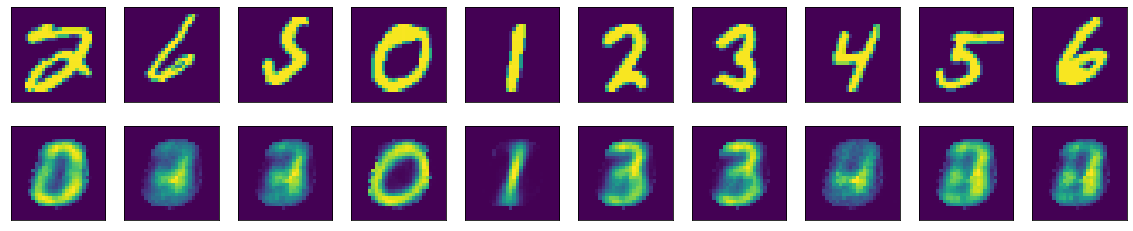

In [10]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

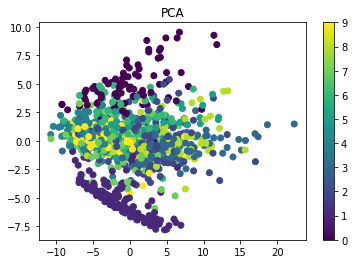

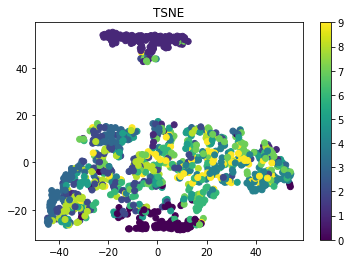

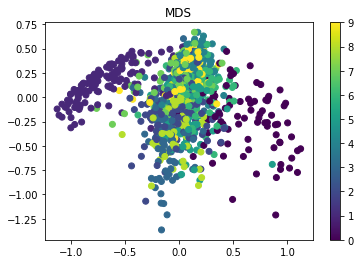

In [11]:
with torch.no_grad():
    plot_latent_space(encoded_z.astype(np.float64), labels, 1000)

In [13]:
# clustering
kmodel = KMeans(n_clusters = 10, random_state=0) # random_state for rng seed 
kmodel = kmodel.fit(encoded_z)
kpredictions = kmodel.predict(encoded_z)
accuracy = np.round(acc(labels, kpredictions), 5)
print('acc = %.5f' % (accuracy))

acc = 0.30670


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


## Training with also clustering losses

In [14]:
def intra_cluster_loss(z_same):
    dist = torch.cdist(z_same, z_same)
    dist = torch.mean(dist,dim=1)
    loss = torch.sum(dist)
    loss = torch.div(loss, z_same.shape[0])
    return loss

def inter_cluster_loss(z_same, z_diff):
    dist = torch.cdist(z_diff, z_same)
    dist = torch.mean(dist,dim=1)
    loss = torch.sum(dist)
    loss = torch.div(loss, z_diff.shape[0])
    return loss

In [15]:
epochs = 100

for epoch in range(epochs):
    loss = 0
    tot_recon_loss = 0
    tot_intra_loss = 0
    tot_inter_loss = 0
    for images, labels in train_loader:
        # reshape data to [N, 784] matrix
        # load it to the active device
        images = images.view(-1, 784).to(device)
        z = np.array([])
        # take labels subset
        images = images[labels < 5]
        labels = labels[labels < 5]
        
        for i in range(5): # iter on labels
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
            label = i

            # compute encodings
            outputs, z = model(images)
            
            # partition encodings and images by label
            z_same = z[labels == label]
            z_diff = z[labels != label]
            outputs_same = outputs[labels == label]
            images_same = images[labels == label]

            # compute training reconstruction loss
            recon_loss = criterion(outputs_same, images_same)
            intra_loss = intra_cluster_loss(z_same)
            inter_loss = inter_cluster_loss(z_same, z_diff) 
            
            inter_loss_weight = intra_loss.item() / inter_loss.item()
            alpha = 0.99

            total_loss = alpha * recon_loss + (1 - alpha) * (intra_loss - inter_loss_weight * inter_loss)
            
            # compute accumulated gradients
            total_loss.backward()
            
            # perform parameter update based on current gradients
            optimizer.step()
            
            # add the mini-batch training loss to epoch loss
            loss += total_loss.item()
            tot_recon_loss += recon_loss.item()
            tot_intra_loss += intra_loss.item()
            tot_inter_loss += inter_loss.item()

        # compute the epoch training loss
        loss = loss / len(images)
        tot_recon_loss = tot_recon_loss / len(images)
        tot_intra_loss = tot_intra_loss / len(images)
        tot_inter_loss = tot_inter_loss / len(images)
        print("Epoch : {}/{}, total loss = {:.8f}, recon loss = {:.8f}, intra loss = {:.8f}, inter loss = {:.8f}".format(epoch, epochs, loss, tot_recon_loss, tot_intra_loss, tot_inter_loss))

Epoch : 0/3, total loss = 0.00000859, recon loss = 0.00000867, intra loss = 0.00097144, inter loss = 0.00164114
Epoch : 1/3, total loss = 0.00000861, recon loss = 0.00000870, intra loss = 0.00088937, inter loss = 0.00177737
Epoch : 2/3, total loss = 0.00000893, recon loss = 0.00000902, intra loss = 0.00078796, inter loss = 0.00184669


In [16]:
z = 0
labels = 0
with torch.no_grad():
    for images, labels in train_loader:
        images = images.view(-1, 784).to(device)
        
        # NOTE: if you want to see results on training "categories" just put "<" instead of ">="
        images = images[labels >= 5]
        labels = labels[labels >= 5]
        
        _, z = model(images)
        z = z.cpu()

In [17]:
# clustering
kmodel = KMeans(n_clusters = 10, random_state=0) # random_state for rng seed 
kmodel = kmodel.fit(z)
kpredictions = kmodel.predict(z)
accuracy = np.round(acc(labels.cpu().numpy(), kpredictions), 5)
print('acc = %.5f' % (accuracy))

acc = 0.27323


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


## Results on test set

In [19]:
test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10000, shuffle=False
)

encoded_z = np.array([])
labels = np.array([])

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 784).to(device)

        # take labels subset
        images = images[labels >= 5]
        labels = labels[labels >= 5]

        reconstruction, encoded = model(images)
        encoded_z = encoded.cpu().numpy()

### Visualize Results

Let's try to reconstruct some test images using our trained autoencoder.

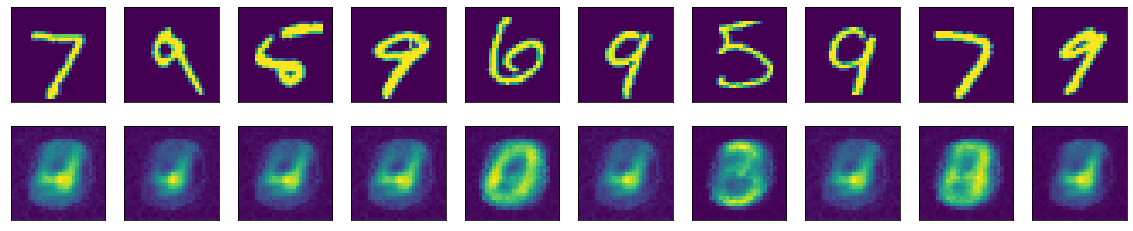

In [20]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(images[index].cpu().numpy().reshape(28, 28))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()